# Leveraging VGG To Create Art With Blended Styles

# Final Project
## COMSW4995: Applied Deep Learning

# Style Blending with Neural Style Transfer

This notebook demonstrates how to use a neural style transfer model to blend multiple artistic styles and apply them to a content image. Inspired by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576)
, this implementation uses VGG-19 for feature extraction and introduces a way to combine two artistic styles by assigning weights to each. You can use it to create unique hybrid visuals that mix styles while preserving the structure of the content image.

## What’s Inside:

- Setting up the content and style images.
- Understanding how the neural network works with style blending.
- Generating and visualizing results for single-style and blended-style transfers.

## Getting Started

Run the notebook to try it yourself - just upload your content and style images and tweak the blending weights to see the results! Check out the references for more details on the original method.

## References

- Gatys, Ecker, and Bethge. [A Neural Algorithm of Artistic Style (2015)](https://arxiv.org/abs/1508.06576)
- Original implementation: [GitHub Repository](https://github.com/tjwhitaker/a-neural-algorithm-of-artistic-style/tree/master)

## Installs

In [169]:
pip install torch torchvision pillow numpy matplotlib

## General Imports

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import vgg11, vgg16, vgg19
from torch.optim import Adam

from PIL import Image
import copy
import numpy as np
import matplotlib.pyplot as plt


# Implementation

## Settings

In [156]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIZE = 256 # before: 512
EPOCHS = 200
STYLE_PATH = '/input/raphael.jpg'
STYLE_PATH2 = '/input/matisse.jpg'
CONTENT_PATH = '/input/portrait.jpg'
OUTPUT_PATH0 = '/output/portrait0.png'
OUTPUT_PATH = '/output/portrait.png'
OUTPUT_PATH1 = '/output/portrait1.png'
OUTPUT_PATH2 = '/output/portrait2.png'
OUTPUT_PATH3 = '/output/portrait3.png'
STYLE_WEIGHT = 1e4
CONTENT_WEIGHT = 1

STYLE_PATHS = ['/input/raphael.jpg', '/input/matisse.jpg']  # Multiple style images
STYLE_WEIGHTS = [0.5, 0.5]  # Equal weight for both styles
STYLE_WEIGHTS2 = [0.25, 0.75]
STYLE_WEIGHTS3 = [0.75, 0.25]

## Utils

In [157]:
# Image Transforms
SIZE = 224 # before: 512
# Image Transforms
loader = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.CenterCrop(SIZE),
    transforms.ToTensor()
])
unloader = transforms.ToPILImage()

def load_image(path):
    image = loader(Image.open(path)).unsqueeze(0)
    return image.to(DEVICE, torch.float)

def save_image(tensor, path):
    image = unloader(tensor.cpu().clone().squeeze(0))
    image.save(path)

## Model (First and Second Style)

In [158]:
# Content Loss Layer
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Style Loss Layer
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

# Normalization Layer
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, image):
        return (image - self.mean) / self.std

# Create style transfer model with loss layers
def style_cnn(cnn, device, normalization_mean, normalization_std, style_image, content_image):
    # Desired layers for style and content - Insert loss layers after these desired layers
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    content_layers = ['conv_4']
    # Copy network to work on
    cnn = copy.deepcopy(cnn)
    # Normalizing image
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)
    # Keeping track of losses
    style_losses = []
    content_losses = []
    # Keeping track of conv layers
    i = 0
    # Looping through VGG layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'

        # Adding layer to model
        model.add_module(name, layer)

        # Inserting style loss layer
        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

        # Inserting content loss layer
        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

    # Geting rid (trimming) of unneeded layers after our final losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]

    return model, style_losses, content_losses

## Main (First Style)

In [159]:
# Load style and content images
style_image = load_image(STYLE_PATH)
content_image = load_image(CONTENT_PATH)

# Load Pretrained VGG and Normalization Tensors
cnn = vgg19(pretrained=True).features.to(DEVICE).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# Initialize (boostrapping) target image with content image
target_image = content_image.clone()

# Build the model
style_model, style_losses, content_losses = style_cnn(
    cnn, DEVICE, cnn_normalization_mean, cnn_normalization_std, style_image, content_image
)

# Define the optimization algorithm
optimizer = optim.LBFGS([target_image.requires_grad_()])

# Run style transfer
run = [0]
while run[0] < EPOCHS:
    # Closure function for LBFGS algorithm
    def closure():
        # Makes sure to keep target values between 0 and 1
        target_image.data.clamp_(0, 1)

        optimizer.zero_grad()
        style_model(target_image)
        style_score = 0
        content_score = 0

        for s1 in style_losses:
          style_score += s1.loss
        for c1 in content_losses:
          content_score += c1.loss

        style_score *= STYLE_WEIGHT
        content_score *= CONTENT_WEIGHT

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
          print('Run: {}'.format(run))
          print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
          print()

        return style_score + content_score

    optimizer.step(closure)

target_image.data.clamp_(0, 1)

save_image(target_image, OUTPUT_PATH)

<ipython-input-158-7dac7679a085>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-158-7dac7679a085>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Run: [10]
Style Loss: 6.149722 Content Loss: 2.741923

Run: [20]
Style Loss: 2.209547 Content Loss: 2.153817

Run: [30]
Style Loss: 1.592303 Content Loss: 1.808540

Run: [40]
Style Loss: 1.466317 Content Loss: 1.683282

Run: [50]
Style Loss: 1.399866 Content Loss: 1.632324

Run: [60]
Style Loss: 1.343462 Content Loss: 1.600127

Run: [70]
Style Loss: 1.281717 Content Loss: 1.585286

Run: [80]
Style Loss: 1.222925 Content Loss: 1.576905

Run: [90]
Style Loss: 1.167700 Content Loss: 1.572588

Run: [100]
Style Loss: 1.117609 Content Loss: 1.569585

Run: [110]
Style Loss: 1.073264 Content Loss: 1.565045

Run: [120]
Style Loss: 1.034471 Content Loss: 1.561948

Run: [130]
Style Loss: 1.000528 Content Loss: 1.559764

Run: [140]
Style Loss: 0.966960 Content Loss: 1.560730

Run: [150]
Style Loss: 0.939568 Content Loss: 1.559499

Run: [160]
Style Loss: 0.915098 Content Loss: 1.559861

Run: [170]
Style Loss: 0.892952 Content Loss: 1.561263

Run: [180]
Style Loss: 0.874735 Content Loss: 1.561643

R

## Main (Second Style)

In [160]:
# Load style and content images
style_image = load_image(STYLE_PATH2)
content_image = load_image(CONTENT_PATH)

# Load Pretrained VGG and Normalization Tensors
cnn = vgg19(pretrained=True).features.to(DEVICE).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# Initialize (boostrapping) target image with content image
target_image = content_image.clone()

# Build the model
style_model, style_losses, content_losses = style_cnn(
    cnn, DEVICE, cnn_normalization_mean, cnn_normalization_std, style_image, content_image
)

# Define the optimization algorithm
optimizer = optim.LBFGS([target_image.requires_grad_()])

# Run style transfer
run = [0]
while run[0] < EPOCHS:
    # Closure function for LBFGS algorithm
    def closure():
        # Makes sure to keep target values between 0 and 1
        target_image.data.clamp_(0, 1)

        optimizer.zero_grad()
        style_model(target_image)
        style_score = 0
        content_score = 0

        for s1 in style_losses:
          style_score += s1.loss
        for c1 in content_losses:
          content_score += c1.loss

        style_score *= STYLE_WEIGHT
        content_score *= CONTENT_WEIGHT

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
          print('Run: {}'.format(run))
          print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
          print()

        return style_score + content_score

    optimizer.step(closure)

target_image.data.clamp_(0, 1)

save_image(target_image, OUTPUT_PATH0)

<ipython-input-158-7dac7679a085>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-158-7dac7679a085>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Run: [10]
Style Loss: 11.168574 Content Loss: 4.946942

Run: [20]
Style Loss: 4.115772 Content Loss: 5.319861

Run: [30]
Style Loss: 2.537489 Content Loss: 4.642087

Run: [40]
Style Loss: 2.134741 Content Loss: 4.270248

Run: [50]
Style Loss: 1.911317 Content Loss: 4.109318

Run: [60]
Style Loss: 1.750431 Content Loss: 4.038325

Run: [70]
Style Loss: 1.629459 Content Loss: 3.971617

Run: [80]
Style Loss: 1.527872 Content Loss: 3.939310

Run: [90]
Style Loss: 1.467288 Content Loss: 3.904586

Run: [100]
Style Loss: 1.402533 Content Loss: 3.898461

Run: [110]
Style Loss: 1.351686 Content Loss: 3.902270

Run: [120]
Style Loss: 1.341345 Content Loss: 3.881033

Run: [130]
Style Loss: 1.331185 Content Loss: 3.957262

Run: [140]
Style Loss: 1.337592 Content Loss: 4.073597

Run: [150]
Style Loss: 1.283663 Content Loss: 3.936197

Run: [160]
Style Loss: 1.308071 Content Loss: 3.988972

Run: [170]
Style Loss: 1.407192 Content Loss: 4.471496

Run: [180]
Style Loss: 1.299961 Content Loss: 4.087967



## Enhanced Model - Weights [0.5, 0.5]

In [161]:
# Content Loss Layer
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Style Loss Layer
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = sum(w * gram_matrix(f).detach() for w, f in zip(STYLE_WEIGHTS, target_features))

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

# Normalization Layer
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1).to(DEVICE)
        self.std = std.clone().detach().view(-1, 1, 1).to(DEVICE)

    def forward(self, image):
        return (image - self.mean) / self.std

# Style Transfer Model
def style_cnn(cnn, device, normalization_mean, normalization_std, style_images, content_image):
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    content_layers = ['conv_4']
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    style_losses = []
    content_losses = []
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        model.add_module(name, layer)

        if name in style_layers:
            # Compute features for all style images
            target_features = [model(style_image).detach() for style_image in style_images]
            style_loss = StyleLoss(target_features)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]

    return model, style_losses, content_losses

## Main

In [162]:
# Load images
style_images = [load_image(path) for path in STYLE_PATHS]  # Load multiple style images
content_image = load_image(CONTENT_PATH)

# Load Pretrained VGG and Normalization Tensors
cnn = vgg19(pretrained=True).features.to(DEVICE).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# Initialize (bootstrapping) target image
target_image = content_image.clone()

# Build the model
style_model, style_losses, content_losses = style_cnn(
    cnn, DEVICE, cnn_normalization_mean, cnn_normalization_std, style_images, content_image
)

# Define the optimization algorithm
optimizer = optim.LBFGS([target_image.requires_grad_()])

# Run Style Transfer
run = [0]
while run[0] < EPOCHS:
    def closure():
        target_image.data.clamp_(0, 1)
        optimizer.zero_grad()
        style_model(target_image)
        style_score = sum(s.loss for s in style_losses)
        content_score = sum(c.loss for c in content_losses)

        style_score *= STYLE_WEIGHT
        content_score *= CONTENT_WEIGHT
        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
            print(f"Run: {run[0]}, Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")
        return loss

    optimizer.step(closure)

# Save the final image
target_image.data.clamp_(0, 1)
save_image(target_image, OUTPUT_PATH1)

Run: 10, Style Loss: 5.9157, Content Loss: 2.9682
Run: 20, Style Loss: 2.1574, Content Loss: 2.4404
Run: 30, Style Loss: 1.6928, Content Loss: 2.0085
Run: 40, Style Loss: 1.5173, Content Loss: 1.8883
Run: 50, Style Loss: 1.4052, Content Loss: 1.8418
Run: 60, Style Loss: 1.3123, Content Loss: 1.8114
Run: 70, Style Loss: 1.2354, Content Loss: 1.7914
Run: 80, Style Loss: 1.1635, Content Loss: 1.7830
Run: 90, Style Loss: 1.1088, Content Loss: 1.7722
Run: 100, Style Loss: 1.0604, Content Loss: 1.7672
Run: 110, Style Loss: 1.0205, Content Loss: 1.7676
Run: 120, Style Loss: 0.9927, Content Loss: 1.7627
Run: 130, Style Loss: 0.9678, Content Loss: 1.7617
Run: 140, Style Loss: 0.9454, Content Loss: 1.7685
Run: 150, Style Loss: 0.9294, Content Loss: 1.7705
Run: 160, Style Loss: 1.0133, Content Loss: 2.1103
Run: 170, Style Loss: 0.8990, Content Loss: 1.8361
Run: 180, Style Loss: 0.8970, Content Loss: 1.7832
Run: 190, Style Loss: 0.8984, Content Loss: 1.7615
Run: 200, Style Loss: 0.8964, Content Lo

## Enhanced Model - Weights [0.25, 0.75]

In [163]:
# Content Loss Layer
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Style Loss Layer
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = sum(w * gram_matrix(f).detach() for w, f in zip(STYLE_WEIGHTS2, target_features))

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

# Normalization Layer
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1).to(DEVICE)
        self.std = std.clone().detach().view(-1, 1, 1).to(DEVICE)

    def forward(self, image):
        return (image - self.mean) / self.std

# Style Transfer Model
def style_cnn(cnn, device, normalization_mean, normalization_std, style_images, content_image):
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    content_layers = ['conv_4']
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    style_losses = []
    content_losses = []
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        model.add_module(name, layer)

        if name in style_layers:
            # Compute features for all style images
            target_features = [model(style_image).detach() for style_image in style_images]
            style_loss = StyleLoss(target_features)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]

    return model, style_losses, content_losses

## Main

In [164]:
# Load images
style_images = [load_image(path) for path in STYLE_PATHS]  # Load multiple style images
content_image = load_image(CONTENT_PATH)

# Load Pretrained VGG and Normalization Tensors
cnn = vgg19(pretrained=True).features.to(DEVICE).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# Initialize (bootstrapping) target image
target_image = content_image.clone()

# Build the model
style_model, style_losses, content_losses = style_cnn(
    cnn, DEVICE, cnn_normalization_mean, cnn_normalization_std, style_images, content_image
)

# Define the optimization algorithm
optimizer = optim.LBFGS([target_image.requires_grad_()])

# Run Style Transfer
run = [0]
while run[0] < EPOCHS:
    def closure():
        target_image.data.clamp_(0, 1)
        optimizer.zero_grad()
        style_model(target_image)
        style_score = sum(s.loss for s in style_losses)
        content_score = sum(c.loss for c in content_losses)

        style_score *= STYLE_WEIGHT
        content_score *= CONTENT_WEIGHT
        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
            print(f"Run: {run[0]}, Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")
        return loss

    optimizer.step(closure)

# Save the final image
target_image.data.clamp_(0, 1)
save_image(target_image, OUTPUT_PATH2)

Run: 10, Style Loss: 7.9953, Content Loss: 4.0883
Run: 20, Style Loss: 2.9127, Content Loss: 3.5638
Run: 30, Style Loss: 1.9909, Content Loss: 3.0613
Run: 40, Style Loss: 1.7570, Content Loss: 2.8397
Run: 50, Style Loss: 1.6059, Content Loss: 2.7671
Run: 60, Style Loss: 1.4900, Content Loss: 2.7164
Run: 70, Style Loss: 1.3893, Content Loss: 2.6881
Run: 80, Style Loss: 1.3089, Content Loss: 2.6670
Run: 90, Style Loss: 1.2486, Content Loss: 2.6495
Run: 100, Style Loss: 1.1999, Content Loss: 2.6403
Run: 110, Style Loss: 1.1600, Content Loss: 2.6328
Run: 120, Style Loss: 1.1559, Content Loss: 2.7232
Run: 130, Style Loss: 1.1192, Content Loss: 2.6279
Run: 140, Style Loss: 1.1055, Content Loss: 2.6354
Run: 150, Style Loss: 1.0822, Content Loss: 2.6490
Run: 160, Style Loss: 1.0845, Content Loss: 2.7531
Run: 170, Style Loss: 1.0596, Content Loss: 2.6625
Run: 180, Style Loss: 1.0963, Content Loss: 2.7956
Run: 190, Style Loss: 1.0902, Content Loss: 2.8122
Run: 200, Style Loss: 1.0521, Content Lo

## Enhanced Model - Weights [0.75, 0.25]

In [165]:
# Content Loss Layer
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Style Loss Layer
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = sum(w * gram_matrix(f).detach() for w, f in zip(STYLE_WEIGHTS3, target_features))

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

# Normalization Layer
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1).to(DEVICE)
        self.std = std.clone().detach().view(-1, 1, 1).to(DEVICE)

    def forward(self, image):
        return (image - self.mean) / self.std

# Style Transfer Model
def style_cnn(cnn, device, normalization_mean, normalization_std, style_images, content_image):
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    content_layers = ['conv_4']
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    style_losses = []
    content_losses = []
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        model.add_module(name, layer)

        if name in style_layers:
            # Compute features for all style images
            target_features = [model(style_image).detach() for style_image in style_images]
            style_loss = StyleLoss(target_features)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]

    return model, style_losses, content_losses

## Main

In [166]:
# Load images
style_images = [load_image(path) for path in STYLE_PATHS]  # Load multiple style images
content_image = load_image(CONTENT_PATH)

# Load Pretrained VGG and Normalization Tensors
cnn = vgg19(pretrained=True).features.to(DEVICE).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# Initialize (bootstrapping) target image
target_image = content_image.clone()

# Build the model
style_model, style_losses, content_losses = style_cnn(
    cnn, DEVICE, cnn_normalization_mean, cnn_normalization_std, style_images, content_image
)

# Define the optimization algorithm
optimizer = optim.LBFGS([target_image.requires_grad_()])

# Run Style Transfer
run = [0]
while run[0] < EPOCHS:
    def closure():
        target_image.data.clamp_(0, 1)
        optimizer.zero_grad()
        style_model(target_image)
        style_score = sum(s.loss for s in style_losses)
        content_score = sum(c.loss for c in content_losses)

        style_score *= STYLE_WEIGHT
        content_score *= CONTENT_WEIGHT
        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
            print(f"Run: {run[0]}, Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")
        return loss

    optimizer.step(closure)

# Save the final image
target_image.data.clamp_(0, 1)
save_image(target_image, OUTPUT_PATH3)

Run: 10, Style Loss: 5.3980, Content Loss: 2.5543
Run: 20, Style Loss: 1.9087, Content Loss: 1.8692
Run: 30, Style Loss: 1.4957, Content Loss: 1.5528
Run: 40, Style Loss: 1.3791, Content Loss: 1.4309
Run: 50, Style Loss: 1.2949, Content Loss: 1.3910
Run: 60, Style Loss: 1.2282, Content Loss: 1.3680
Run: 70, Style Loss: 1.1593, Content Loss: 1.3549
Run: 80, Style Loss: 1.0916, Content Loss: 1.3515
Run: 90, Style Loss: 1.0333, Content Loss: 1.3471
Run: 100, Style Loss: 0.9894, Content Loss: 1.3420
Run: 110, Style Loss: 0.9510, Content Loss: 1.3403
Run: 120, Style Loss: 0.9197, Content Loss: 1.3380
Run: 130, Style Loss: 0.8920, Content Loss: 1.3382
Run: 140, Style Loss: 0.8701, Content Loss: 1.3374
Run: 150, Style Loss: 0.8486, Content Loss: 1.3395
Run: 160, Style Loss: 0.8323, Content Loss: 1.3473
Run: 170, Style Loss: 0.8266, Content Loss: 1.3321
Run: 180, Style Loss: 0.8053, Content Loss: 1.3483
Run: 190, Style Loss: 0.7961, Content Loss: 1.4020
Run: 200, Style Loss: 0.7849, Content Lo

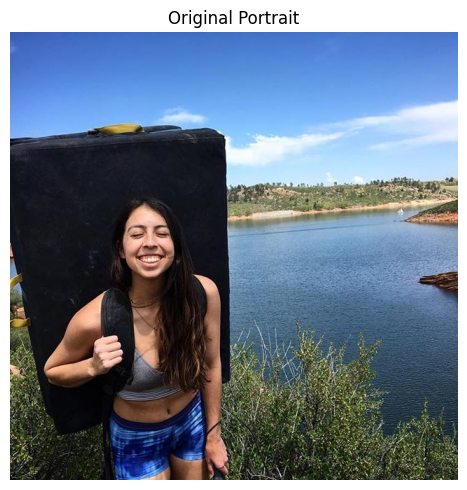

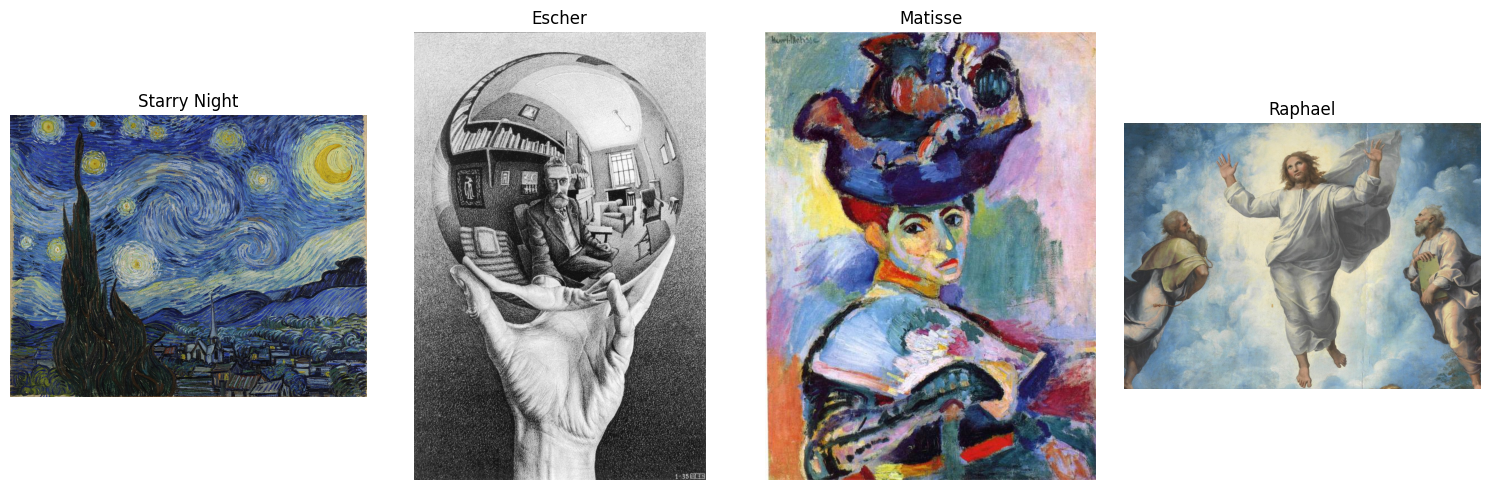

In [167]:
# File paths
content_image_path = "/content/input/portrait.jpg"
style_image_paths = {
    "Starry Night": "/content/input/starry-night.jpg",
    "Escher": "/content/input/escher.jpg",
    "Matisse": "/content/input/matisse.jpg",
    "Raphael": "/content/input/raphael.jpg"
}

# Load content and style images
content_image = Image.open(content_image_path)
style_images = {
    label: Image.open(path)
    for label, path in style_image_paths.items()
}

# Plot content image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # Single image for content
ax.imshow(content_image)
ax.set_title("Original Portrait")
ax.axis("off")

plt.tight_layout()
plt.show()

# Plot style images
fig, axes = plt.subplots(1, len(style_images), figsize=(15, 5))  # Horizontal layout for style images
for ax, (label, img) in zip(axes, style_images.items()):
    if label == "Escher":
        ax.imshow(img, cmap="gray") # Escher is originally B&W
    else:
        ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


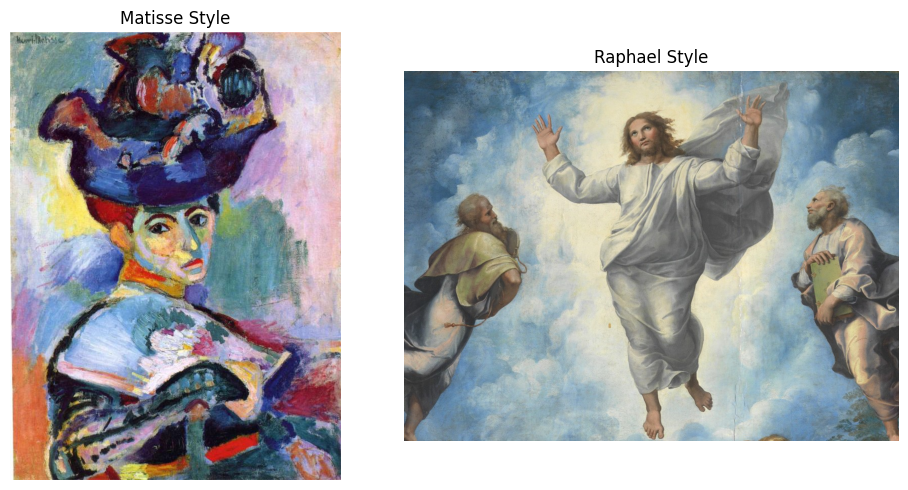

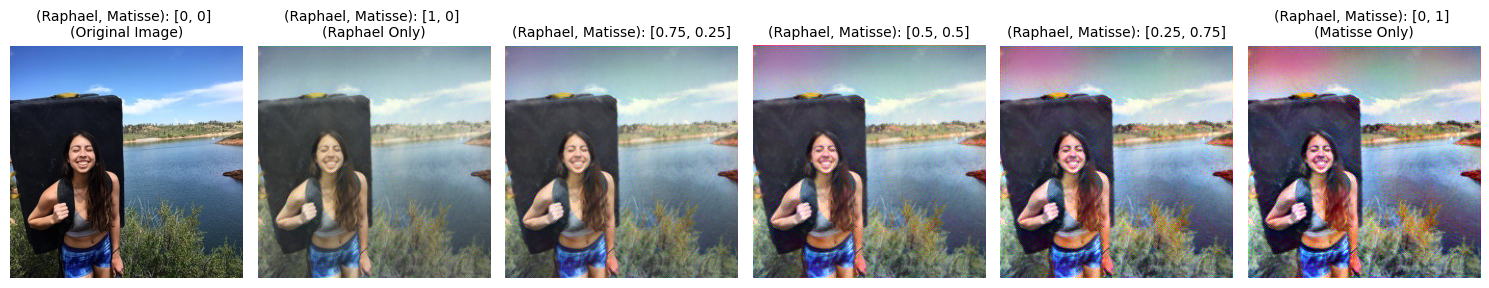

In [168]:
# Results Visualization
style_images = {
    "Matisse Style": f"{STYLE_PATH2}",
    "Raphael Style": f"{STYLE_PATH}"
}
blended_images = {
    "(Raphael, Matisse): [0, 0] \n(Original Image)": f"{CONTENT_PATH}",
    "(Raphael, Matisse): [1, 0] \n(Raphael Only)": f"{OUTPUT_PATH}",
    "(Raphael, Matisse): [0.75, 0.25]": f"{OUTPUT_PATH3}",
    "(Raphael, Matisse): [0.5, 0.5]": f"{OUTPUT_PATH1}",
    "(Raphael, Matisse): [0.25, 0.75]": f"{OUTPUT_PATH2}",
    "(Raphael, Matisse): [0, 1] \n(Matisse Only)": f"{OUTPUT_PATH0}",
}

loaded_styles = {label: Image.open(path) for label, path in style_images.items()}
loaded_blended = {label: Image.open(path) for label, path in blended_images.items()}

fig, axes = plt.subplots(1, len(loaded_styles), figsize=(10, 5))  # Adjust for style images
for ax, (label, img) in zip(axes, loaded_styles.items()):
    ax.imshow(img)
    ax.set_title(label)  # Set the label
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(loaded_blended), figsize=(15, 5))  # Adjust for blended images
for ax, (label, img) in zip(axes, loaded_blended.items()):
    ax.imshow(img)
    ax.set_title(label, fontsize=10) # Set the label
    ax.axis('off')

plt.tight_layout()
plt.show()